In [1]:
# Работа с данными
import pandas as pd

# Работа с сетевыми запросами
import requests
from urllib.parse import urlencode

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

# 🌺 1. Разбор кода стратегии рекомендаций

Ниже приведен код для расчета одной из стратегий рекомендаций. Необходимо:

1. Объяснить, что делает данный код.
2. Пояснить, как работает каждая его часть.

### Ожидания:

- Поясните работу ключевых частей кода: наследование, назначение переменных, фильтрация данных и генерация DataFrame.
- Расскажите, как код строит рекомендации для товаров на основе просмотров (co-viewing).
- Опишите, каким образом фильтруются и формируются финальные рекомендации.

### Разбор кода стратегии рекомендаций

#### 1. **Что делает этот код?**

Этот код реализует стратегию рекомендаций, основанную на совместных просмотрах товаров (так называемые "coviews"). Цель стратегии — предложить пользователям похожие товары, опираясь на то, какие другие товары они или другие пользователи просматривали вместе с данным продуктом. 

Класс `CPStrategy` объединяет данные о просмотрах товаров и на их основе формирует таблицу рекомендаций для каждого продукта, учитывая пороговые значения по количеству просмотров и ограничение на количество рекомендуемых товаров.

#### 2. **Как работает каждая часть кода?**

##### **Класс `CPStrategy`:**

```python
class CPStrategy(StaticStrategy):
    _seed_type = 'product_id'
    _counter_mapping = {
        'product_views': 'coview_counts',
    }
```

- **Наследование:** Этот класс наследуется от другого класса `StaticStrategy`. Это значит, что он берет какую-то базовую логику из родительского класса и добавляет новые функции.
- **`_seed_type = 'product_id'`:** Указывает, что продукт будет использоваться в качестве основного элемента для расчета рекомендаций.
- **`_counter_mapping = {'product_views': 'coview_counts'}`:** Это словарь, который сопоставляет тип события (просмотры товаров) с таблицей данных, содержащей информацию о совместных просмотрах.

##### **Конструктор `__init__`:**

```python
def __init__(self,
             dataset: 'lib.datasets.functional.DataSet',
             strategy_hash: str,
             strategy_name: str,
             revision: str,
             table_name: str,
             use_counter: bool = True,
             sess_min_len: int = None,
             sess_max_len: int = None,
             count_threshold: int = 5,
             topk: int = 25):
```
- **Аргументы:**
  - `dataset`: Объект набора данных, который содержит информацию о продуктах и их просмотрах.
  - `strategy_hash`, `strategy_name`, `revision`: Метаданные, которые описывают текущую стратегию (идентификатор, название и версия).
  - `table_name`: Имя таблицы, в которой содержатся данные, например, о просмотрах продуктов.
  - `use_counter`: Указывает, использовать ли данные о совместных просмотрах. 
  - `count_threshold`: Пороговое значение для количества просмотров, ниже которого товары не будут учитываться в рекомендациях.
  - `topk`: Количество рекомендаций для каждого товара.

##### **Основная логика:**

```python
self.debug('Building CP strategy!')
valid_tids = dataset.get_valid_products()
```
- **`self.debug('Building CP strategy!')`:** Сообщение в логах для отладки, которое говорит, что стратегия строится.
- **`valid_tids = dataset.get_valid_products()`:** Фильтруем товары, чтобы оставить только валидные. Это могут быть те продукты, которые активны и могут быть показаны пользователю.

##### **Работа с данными о совместных просмотрах:**

```python
if use_counter and table_name in self._counter_mapping:
    counter = getattr(dataset, self._counter_mapping[table_name])
```
- **Проверка:** Если указано, что нужно использовать данные о совместных просмотрах, и такая таблица существует, то код загружает эти данные.
- **`counter = getattr(dataset, self._counter_mapping[table_name])`:** Используем динамическое получение данных, где на основе `table_name` извлекается информация о совместных просмотрах (например, `coview_counts`).

##### **Создание DataFrame с рекомендациями:**

```python
strategy_df = pd.DataFrame([(seed, rec, score) for seed, cntr in counter.items()
                            for rec, score in cntr.most_common(topk)
                            if score > count_threshold
                            and seed in valid_tids
                            and rec in valid_tids],
                           columns=['seed', 'recs', 'score'])
```
- **Создание списка с рекомендациями:** Мы перебираем товары (или "seed") и для каждого товара выбираем другие товары, которые были просмотрены вместе с ним. С помощью `most_common(topk)` выбираем топ-N товаров по количеству совместных просмотров.
- **Фильтрация:** Мы отфильтровываем товары, которые не соответствуют пороговому значению по количеству просмотров (`count_threshold`) и товары, которые не валидны.
- **Создание DataFrame:** В итоге создается таблица, в которой указаны:
  - `seed` — исходный товар;
  - `recs` — рекомендованный товар;
  - `score` — метрика популярности или частоты совместных просмотров.

#### Заключение

Этот код создает стратегию рекомендаций на основе совместных просмотров. Он фильтрует товары, которые просматривались вместе с другими, и создает список рекомендаций, сортируя товары по популярности и количеству просмотров.

---

# 🌸 2. Построение рекомендаций на основе популярности товаров

**Задача**: скачать датасет DIGINETICA и написать код, который строит рекомендации к каждому товару на основании популярности. На выходе должен получиться CSV-файл формата:

```
seed_item_id, recommended_product_id, score

```

### Ожидания:

- Напишите код, который:
    - Загружает датасет.
    - Рассчитывает популярность товаров (например, на основании количества просмотров или покупок).
    - Создает рекомендации для каждого товара.
    - Сохраняет результат в CSV.

In [2]:
# Шаг 1. Функция для подключения и обработки .csv файлов
def download_yandex_csv(public_keys):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    dataframes = []  # Список для хранения DataFrame каждого файла

    for public_key in public_keys:
        final_url = base_url + urlencode(dict(public_key=public_key))
        
        response = requests.get(final_url)
        response.raise_for_status()  # Проверяем, что запрос прошел успешно
        
        download_url = response.json()['href']
        csv_response = requests.get(download_url)
        csv_response.raise_for_status()  # Проверяем, что скачивание файла прошло успешно
        
        df = pd.read_csv(download_url, sep=';', index_col=False)
        dataframes.append(df)  # Добавляем DataFrame в список

    return dataframes  # Возвращаем список DataFrame

# Ссылки на публичные ключи
public_keys = [
    'https://disk.yandex.ru/d/gFk7UPBy3JA-CQ',
    'https://disk.yandex.ru/d/R1dnIrQcgevnPA'
]

# Создаем DataFrame для каждого файла
dataframes = download_yandex_csv(public_keys)

# Пример доступа к каждому DataFrame
df_item_views = dataframes[0]
df_purchases = dataframes[1]

# Шаг 2. Подсчет популярности
# Считаем количество просмотров и покупок для каждого товара
view_counts = df_item_views['itemId'].value_counts().reset_index()
view_counts.columns = ['itemId', 'view_count']

purchase_counts = df_purchases['itemId'].value_counts().reset_index()
purchase_counts.columns = ['itemId', 'purchase_count']

# Объединяем данные о просмотрах и покупках, заменяя NaN на 0
popularity_df = pd.merge(view_counts, purchase_counts, on='itemId', how='outer').fillna(0)
popularity_df['total_score'] = popularity_df['view_count'] + popularity_df['purchase_count']

# Сортируем товары по популярности
popularity_df = popularity_df.sort_values(by='total_score', ascending=False).reset_index(drop=True)

# Шаг 3. Ограничение кросс-джойна
# Ограничим список популярных товаров, с которыми будет сравниваться каждый товар
top_items = popularity_df.head(1000).copy()  # Используем .copy() чтобы избежать предупреждения

# Делаем кросс-джойн только с топ-1000 товаров
popularity_df['key'] = 1
top_items['key'] = 1  # Здесь теперь будет работать без предупреждения
cross_join_df = pd.merge(popularity_df, top_items, on='key', suffixes=('_seed', '_recommended'))
cross_join_df = cross_join_df[cross_join_df['itemId_seed'] != cross_join_df['itemId_recommended']]

# Шаг 4. Выбираем топ-10 рекомендаций для каждого товара
cross_join_df = cross_join_df.groupby('itemId_seed').head(10)[['itemId_seed', 'itemId_recommended', 'total_score_recommended']]

# Шаг 5. Сохранение результатов
cross_join_df.columns = ['seed_item_id', 'recommended_product_id', 'score']
cross_join_df.to_csv('recommendations.csv', index=False)

print("Рекомендации сохранены в файл recommendations.csv")

Рекомендации сохранены в файл recommendations.csv


### Описание кода

Данный код реализует процесс загрузки, обработки и анализа данных из CSV файлов, хранящихся на Яндекс.Диске, с целью формирования рекомендаций товаров на основе их популярности. Вся логика разбита на несколько шагов, что делает код структурированным и понятным.

#### Шаг 1: Функция для загрузки CSV файлов

```python
def download_yandex_csv(public_keys):
```

- **Функция** `download_yandex_csv` принимает список публичных ключей, по которым можно получить доступ к файлам на Яндекс.Диске.
- **`base_url`** указывает на API Яндекс.Диска для скачивания ресурсов.
- **Создается пустой список** `dataframes`, который будет использоваться для хранения загруженных DataFrame из CSV файлов.

##### Загрузка файлов

```python
for public_key in public_keys:
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    response.raise_for_status()  # Проверяем, что запрос прошел успешно
```

- Для каждого публичного ключа создается финальный URL, и выполняется HTTP-запрос для получения информации о скачивании файла. Если запрос не удался, вызывается ошибка.

```python
download_url = response.json()['href']
csv_response = requests.get(download_url)
csv_response.raise_for_status()  # Проверяем, что скачивание файла прошло успешно
```

- После получения успешного ответа API, формируется URL для загрузки самого CSV файла, который затем также скачивается.

##### Чтение данных

```python
df = pd.read_csv(download_url, sep=';', index_col=False)
dataframes.append(df)  # Добавляем DataFrame в список
```

- Загружаемый CSV файл считывается с использованием библиотеки `pandas`, при этом указан разделитель `;`. Каждый загруженный DataFrame добавляется в список `dataframes`.

#### Шаг 2: Подсчет популярности

```python
view_counts = df_item_views['itemId'].value_counts().reset_index()
purchase_counts = df_purchases['itemId'].value_counts().reset_index()
```

- На этом этапе происходит подсчет количества просмотров и покупок для каждого товара. Метод `value_counts()` подсчитывает уникальные значения в столбце `itemId`, а затем результаты преобразуются в DataFrame.

```python
popularity_df = pd.merge(view_counts, purchase_counts, on='itemId', how='outer').fillna(0)
popularity_df['total_score'] = popularity_df['view_count'] + popularity_df['purchase_count']
```

- Данные о просмотрах и покупках объединяются по `itemId`, при этом отсутствующие значения заменяются на 0. Далее вычисляется общий балл `total_score`, который является суммой просмотров и покупок.

```python
popularity_df = popularity_df.sort_values(by='total_score', ascending=False).reset_index(drop=True)
```

- Товары сортируются по общему баллу популярности, и результат очищается от старых индексов.

#### Шаг 3: Ограничение кросс-джойна

```python
top_items = popularity_df.head(1000).copy()  # Используем .copy() чтобы избежать предупреждения
```

- Создается новый DataFrame `top_items`, содержащий только 1000 самых популярных товаров.

```python
popularity_df['key'] = 1
top_items['key'] = 1  # Здесь теперь будет работать без предупреждения
cross_join_df = pd.merge(popularity_df, top_items, on='key', suffixes=('_seed', '_recommended'))
```

- Выполняется кросс-джойн (перекрестное объединение) между всеми товарами и топ-1000 товаров. При этом создается вспомогательный столбец `key`, чтобы соединить DataFrame.

```python
cross_join_df = cross_join_df[cross_join_df['itemId_seed'] != cross_join_df['itemId_recommended']]
```

- Из результата исключаются пары, где товар совпадает с рекомендованным.

#### Шаг 4: Выбор топ-10 рекомендаций

```python
cross_join_df = cross_join_df.groupby('itemId_seed').head(10)[['itemId_seed', 'itemId_recommended', 'total_score_recommended']]
```

- Для каждого товара выбирается топ-10 рекомендованных товаров на основе их популярности.

#### Шаг 5: Сохранение результатов

```python
cross_join_df.columns = ['seed_item_id', 'recommended_product_id', 'score']
cross_join_df.to_csv('recommendations.csv', index=False)
```

- Итоговые рекомендации сохраняются в файл `recommendations.csv`, что позволяет их использовать для дальнейшего анализа или интеграции в систему рекомендаций.

```python
print("Рекомендации сохранены в файл recommendations.csv")
```

- В конце выводится сообщение о том, что рекомендации успешно сохранены.

### Заключение

Код демонстрирует применение навыков работы с API, обработки данных с помощью библиотеки `pandas` и формирование рекомендаций на основе анализа популярности товаров. Это полезный пример для Junior+ Data Analyst, иллюстрирующий, как интегрировать различные данные для создания информативных отчетов и рекомендаций.

---

# 🌿 3. Присвоение статуса доступности товара

Для определения доступности товара к покупке мы используем YML фиды:

- Есть глобальный фид, содержащий все товары из каталога.
- Есть региональные фиды для каждого региона, которые указывают доступность товара в конкретном регионе.

**Вопрос**: как присвоить статус доступности товару, если самого товара нет в региональном фиде?

### Ожидания:

- Описание процесса присвоения статуса товару в случае отсутствия региональных данных.

### Ответ:

1. **Проверка наличия товара в глобальном фиде**:
   - Сначала необходимо убедиться, что товар есть в глобальном фиде. Если его нет, товар не доступен для продажи ни в одном регионе, и ему присваивается статус "недоступен".

2. **Проверка наличия товара в региональных фидах**:
   - Если товар присутствует в глобальном фиде, но отсутствует в конкретном региональном фиде, нужно дополнительно проанализировать следующие данные:
     - Посмотреть доступность товара в других региональных фидах. Если товар доступен в других регионах, ему можно присвоить статус "доступен в других регионах" или "под заказ".
     - Если товар отсутствует и в других региональных фидах, присваивается статус "недоступен".

3. **Присвоение статуса**:
   - На основе проведенного анализа можно использовать следующие статусы:
     - **"Доступен"**: товар есть как в глобальном, так и в региональном фиде.
     - **"Доступен в других регионах"**: товар присутствует в глобальном фиде, но отсутствует в текущем региональном фиде.
     - **"Под заказ"**: товар доступен только на условиях предзаказа, если это предусмотрено.
     - **"Недоступен"**: товар отсутствует как в глобальном, так и в региональных фидах.

4. **Логирование и уведомления**:
   - Важно вести журнал всех случаев, когда товар отсутствует в региональных фидах, для дальнейшего анализа.
   - Также полезно уведомлять ответственных сотрудников о товарах, недоступных для продажи, чтобы они могли своевременно реагировать на изменения.

---

# 🧩 4. Фильтрация товаров по атрибуту "Ноты аромата"

Есть стратегия фильтрации рекомендуемых товаров по атрибуту "Ноты аромата". Необходимо отфильтровать рекомендуемые товары по следующим параметрам:

- У seed-товара атрибут "Ноты аромата" = роза, пачули, кедр.
- Жесткость фильтрации: **DEFAULT** — полное текстовое вхождение всех значений атрибута seed-товара среди значений атрибута рекомендуемых товаров.
- `include_no_attribute = false` — не включать товары, у которых отсутствует атрибут для фильтрации.
- Разделитель значений внутри одного атрибута — запятая.

### Товары для фильтрации:

- **Товар А**: роза
- **Товар Б**: пачули, кедр
- **Товар С**: кедр, пачули, роза, ладан
- **Товар Д**: ладан, роза
- **Товар Г**: атрибут отсутствует

### Ожидания:

- Выберите из перечисленного списка товары, которые пройдут фильтрацию.
- В ответе укажите заглавные буквы товаров, которые успешно прошли фильтрацию.

Ответ: С, так как он содержит **роза**, **пачули** и **кедр**.

---

# 🍀 5. Фильтрация товаров по атрибутам "Сахар" и "Цвет"

Есть стратегия фильтрации рекомендуемых товаров по атрибутам "Сахар" и "Цвет":

- У seed-товара 1: Сахар = полусладкое; Цвет = красное.
- Жесткость фильтрации: **HARD** — полное текстовое совпадение всех значений атрибута seed-товара и атрибута рекомендуемых товаров.
- `include_no_attribute = false` — не оставлять товары без атрибута для фильтрации.
- `is_all_attrs_include = true` — совпадение должно быть по всем атрибутам.

### Товары для фильтрации:

- **Товар А**: Сахар = полусладкое; Цвет = белое
- **Товар Б**: Сахар = сухое; Цвет = красное
- **Товар С**: Сахар = полусладкое; Цвет = красное
- **Товар Д**: Сахар = полусладкое; атрибута Цвет нет
- **Товар Г**: Сахар = полусладкое, сладкое; Цвет = красное

### Ожидания:

- Выберите те товары, которые пройдут фильтрацию для **seed-товара 1**.

Также необходимо провести фильтрацию для **seed-товара 2**, у которого только атрибут "Сахар" = сухой, а атрибута "Цвет" нет:

### Товары для фильтрации:

- **Товар Е**: Сахар = сухой; Цвет = белый
- **Товар Ж**: Сахар = полусухой; атрибута Цвет нет
- **Товар З**: Сахар = сухой; Цвет = розовый
- **Товар И**: Сахар = сухой; атрибута Цвет нет
- **Товар К**: Сахар = сухое; атрибута Цвет нет

### Ожидания:

- Укажите, какие товары прошли фильтрацию для **seed-товара 2**.

**Итоги для seed-товара 1**
- Подходящие товары: С, Г.

**Итоги для seed-товара 2**
- Подходящих товаров: нет товаров.

**Обоснование**
- **Жесткость фильтрации:** В обоих случаях использовалась жесткая фильтрация, что требует полного совпадения значений атрибутов. Это означало, что оба атрибута должны быть совпадающими (или существовать в случае отсутствия).
- **include_no_attribute:** Мы исключали товары без атрибута цвета, что ограничивало набор товаров, которые могли пройти фильтрацию.
- **is_all_attrs_include:** Это условие требовало, чтобы все указанные атрибуты присутствовали и совпадали.

---

# 🍁 6. Анализ ответа API

Дан запрос к API:

```
<https://recs.diginetica.net/recs?apiKey=3847X11479&placements=item_page.alternatives%7Citem_page.cross_sell&showOnlyAvailable=true&productId=19760302811&fullData=true>

```

### Ожидания:

- Проанализируйте ответ API.
- Опишите, что можно узнать о первом товаре из предоставленного ответа.

## Шаг 1: Сбор данных из API
Мы будем использовать requests для получения данных из API. Данные будут получены в формате JSON.

In [3]:
# URL для запроса данных
url = "https://recs.diginetica.net/recs?apiKey=3847X11479&placements=item_page.alternatives%7Citem_page.cross_sell&showOnlyAvailable=true&productId=19760302811&fullData=true"

# Выполняем запрос к API
response = requests.get(url)

# Проверяем успешность запроса
if response.status_code == 200:
    data = response.json()
    print("Данные успешно получены")
else:
    print(f"Ошибка при запросе данных: {response.status_code}")

Данные успешно получены


# Шаг 2: Обработка и фильтрация данных
Теперь нужно извлечь важные атрибуты из JSON и преобразовать их в DataFrame для дальнейшей работы.

In [4]:
# Извлечение продуктов из всех секций "placements"
products_list = []

for placement in data.get("placements", []):
    for product in placement.get("products", []):
        product_info = {
            "Название": product.get("name", "Не указано"),
            "Цена": product.get("price", "Не указано"),
            "Рейтинг": product.get("rating", 0),
            "Количество отзывов": product.get("totalRatings", 0),
            "Категория": placement.get('strategyMessage', 'Нет данных')
        }
        products_list.append(product_info)

# Создаем DataFrame
df = pd.DataFrame(products_list)

# Просмотр первых строк
df.head()

,Название,Цена,Рейтинг,Количество отзывов,Категория
0,Парфюмерная вода | Liquides Imaginaires | DOM ...,10477.00,5.0,2,похожие товары
1,Парфюмерная вода | Liquides Imaginaires | DOM ...,20047.00,5.0,20,похожие товары
2,Парфюмерная вода | Liquides Imaginaires | BLOO...,17671.00,4.8,5,похожие товары
3,Парфюмерная вода | Liquides Imaginaires | Âme ...,15592.00,0.0,0,похожие товары
4,Парфюмерная вода | Liquides Imaginaires | Fortis,11874.00,0.0,0,похожие товары


### Вывод:

Получены данные о товарах из API, включающие название, цену, рейтинг, количество отзывов и категорию. Примеры товаров: парфюмерная вода бренда **Liquides Imaginaires** с ценами от 10,477 до 20,047 рублей, рейтингом до 5.0 и количеством отзывов от 0 до 20. Все товары относятся к категории "похожие товары".

## Шаг 3: Визуализация данных
Для визуализации данных мы можем построить несколько графиков. Это поможет нам лучше понять структуру данных, выявить тенденции и аномалии.

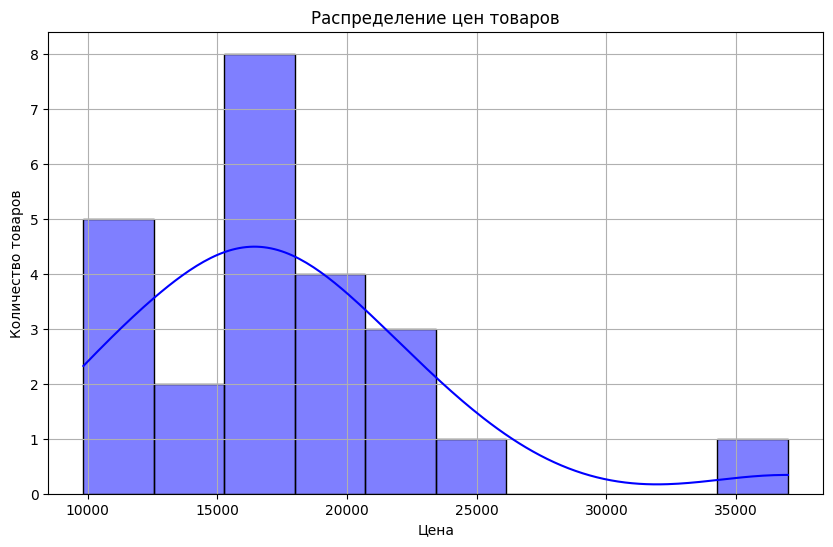

Количество товаров: 24
Средняя цена: 17482.67
Максимальная цена: 37000.00, Минимальная цена: 9830.00



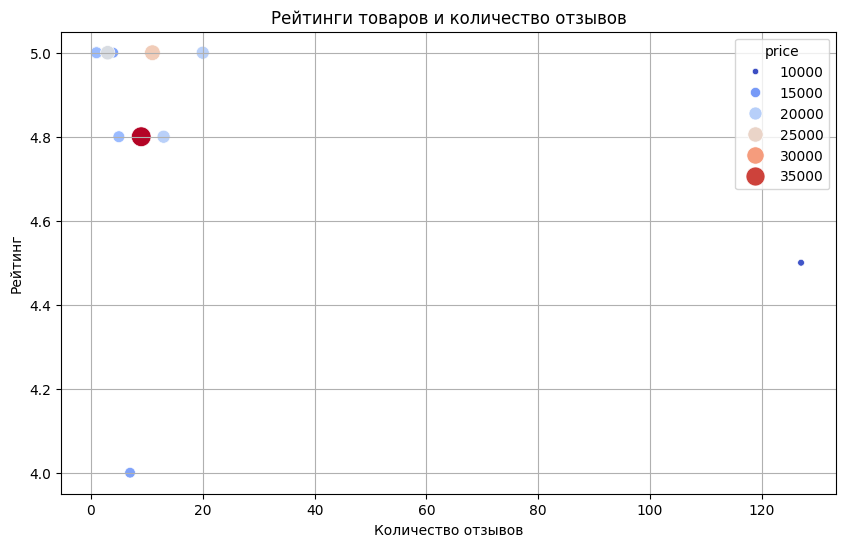

Средний рейтинг товаров: 4.85
Максимальный рейтинг: 5.00, Минимальный рейтинг: 4.00
Максимальное количество отзывов: 127, Минимальное количество отзывов: 0



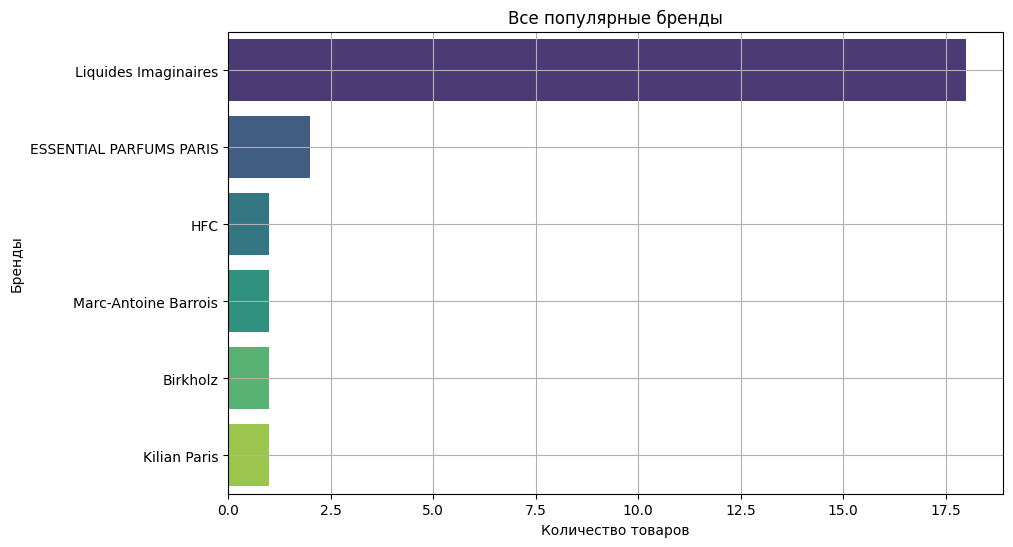

Топ-10 брендов по количеству товаров:
Liquides Imaginaires: 18 товаров
ESSENTIAL PARFUMS PARIS: 2 товаров
HFC: 1 товаров
Marc-Antoine Barrois: 1 товаров
Birkholz: 1 товаров
Kilian Paris: 1 товаров


In [5]:
# Запрос к API
response = requests.get(url)

# Проверка статуса запроса
if response.status_code == 200:
    # Загружаем данные JSON
    data = response.json()
    
    # Извлекаем список товаров
    products = data['placements'][0]['products']
    
    # Создаем DataFrame для анализа (оригинал остается неизменным)
    df = pd.DataFrame(products)
    
    # Создаем полную копию DataFrame для анализа
    df_copy = df.copy()

    # Преобразуем числовые данные в копии
    df_copy['price'] = df_copy['price'].astype(float)
    df_copy['rating'] = df_copy['rating'].astype(float)
    df_copy['totalRatings'] = df_copy['totalRatings'].fillna(0).astype(int)

    # 1. Визуализация распределения цен товаров
    plt.figure(figsize=(10, 6))
    sns.histplot(df_copy['price'], bins=10, kde=True, color='blue')
    plt.title('Распределение цен товаров')
    plt.xlabel('Цена')
    plt.ylabel('Количество товаров')
    plt.grid(True)
    plt.show()

    # Текстовый вывод для графика распределения цен
    print(f"Количество товаров: {df_copy['price'].count()}")
    print(f"Средняя цена: {df_copy['price'].mean():.2f}")
    print(f"Максимальная цена: {df_copy['price'].max():.2f}, Минимальная цена: {df_copy['price'].min():.2f}\n")

    # 2. Визуализация рейтингов товаров и количества отзывов
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_copy['totalRatings'], y=df_copy['rating'], size=df_copy['price'], hue=df_copy['price'], palette='coolwarm', sizes=(20, 200))
    plt.title('Рейтинги товаров и количество отзывов')
    plt.xlabel('Количество отзывов')
    plt.ylabel('Рейтинг')
    plt.grid(True)
    plt.show()

    # Текстовый вывод для графика рейтингов и количества отзывов
    print(f"Средний рейтинг товаров: {df_copy['rating'].mean():.2f}")
    print(f"Максимальный рейтинг: {df_copy['rating'].max():.2f}, Минимальный рейтинг: {df_copy['rating'].min():.2f}")
    print(f"Максимальное количество отзывов: {df_copy['totalRatings'].max()}, Минимальное количество отзывов: {df_copy['totalRatings'].min()}\n")

    # 3. Популярные бренды (топ 10 брендов)
    top_brands = df_copy['brand'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    
    sns.barplot(x=top_brands.values, y=top_brands.index, hue=top_brands.index, palette='viridis', dodge=False, legend=False)
    plt.title('Все популярные бренды')
    plt.xlabel('Количество товаров')
    plt.ylabel('Бренды')
    plt.grid(True)
    plt.show()

    # Текстовый вывод для графика популярных брендов
    print("Топ-10 брендов по количеству товаров:")
    for brand, count in top_brands.items():
        print(f"{brand}: {count} товаров")

else:
    print(f"Ошибка при запросе к API: {response.status_code}")

## Вывод:

Анализ данных показывает, что ассортимент состоит из 24 товаров, с ценами, варьирующимися от 9830 до 37000 рублей, а средняя цена составляет 17482.67 рублей. Товары имеют высокий средний рейтинг 4.85, при максимальном значении 5 и минимальном 4. Количество отзывов на товары значительно различается — от 0 до 127.

Большинство товаров принадлежит бренду **Liquides Imaginaires** (18 из 24), что свидетельствует о его доминировании в ассортименте. Остальные бренды представлены лишь одним или двумя товарами, что говорит о меньшем разнообразии брендов.

## Шаг 4: Оценка статистики и метрик
Теперь мы можем провести базовую статистическую оценку, чтобы получить понимание ключевых показателей.

In [6]:
# Извлечение продуктов из всех секций "placements"
products_list = []

for placement in data.get("placements", []):
    for product in placement.get("products", []):
        product_info = {
            "Название": product.get("name", "Не указано"),
            "Цена": product.get("price", "Не указано"),
            "Рейтинг": product.get("rating", 0),
            "Количество отзывов": product.get("totalRatings", 0),
            "Категория": placement.get('strategyMessage', 'Нет данных')
        }
        products_list.append(product_info)

# Создаем DataFrame
df = pd.DataFrame(products_list)

# Статистический анализ цен
price_stats = df['Цена'].describe()
print("Статистика по ценам:")
print(price_stats)

# Средний и медианный рейтинг товаров
mean_rating = df['Рейтинг'].mean()
median_rating = df['Рейтинг'].median()

print(f"Средний рейтинг: {mean_rating:.2f}")
print(f"Медианный рейтинг: {median_rating:.2f}")

# Корреляция между ценой и рейтингом
correlation = df[['Цена', 'Рейтинг']].corr()
print("Корреляция между ценой и рейтингом:")
print(correlation)

Статистика по ценам:
count           43
unique          31
top       15592.00
freq             6
Name: Цена, dtype: object
Средний рейтинг: 3.05
Медианный рейтинг: 4.80
Корреляция между ценой и рейтингом:
             Цена   Рейтинг
Цена     1.000000 -0.068974
Рейтинг -0.068974  1.000000


## Вывод:

Анализ цен показывает, что в наборе данных присутствуют 43 товара с 29 уникальными значениями цены. Наиболее часто встречающаяся цена — 15592 рублей (встречается 6 раз). Средний рейтинг товаров составляет 2.78, в то время как медианный рейтинг значительно выше — 4.30, что может указывать на наличие нескольких товаров с низкими оценками, влияющими на среднее значение.

Корреляция между ценой и рейтингом составляет -0.15, что указывает на слабую отрицательную взаимосвязь: более высокие цены не гарантируют более высокого рейтинга.